# **FɪꜱꜱɪᴏɴBᴏᴍʙ**


(c) Matt Caplan 2025

Last updated: July 27, 2025

This notebook is a companion to *Improvised Nuclear Weapons with 60\%-Enriched Uranium*

This code simulates the fission burn of a spherical core of uranium with a tamper to estimate nuclear weapon yields. The default parameters use uncompressed cores, as would be expected in gun-type weapons like the Little Boy bomb detonated over Hiroshima or a crude terrorist device.



Adapted from the FissionCore code of B. Cameron Reed, published in:



* Reed, Bruce Cameron. "Student-level numerical simulation of conditions inside an exploding fission-bomb core." Natural Science 2.3 (2010): 139-144. https://doi.org/10.4236/NS.2010.23023

* Reed, B. Cameron. "A brief primer on tamped fission-bomb cores." American Journal of Physics 77.8 (2009): 730-733. https://doi.org/10.1119/1.3125008

This code is for educational purposes only.

Contact: Matt Caplan (mecapl1@ilstu.edu)



In [36]:
# Fully functionalized version, adapts FissionCore of Reed 2009.

import math
import numpy as np

def run_simulation(
    RHOCORZ, ACOR, SIGFCOR, SIGSCOR, NU,
    RHOTAMPZ, ATAMP, SIGSTAMP,
    CORMASS, MASSTAMP,
    GAM, NEUTS, TIME, DT
):
    # Constants
    NA = 6.022142e+23
    EPS = 1.602176e-13
    PI = 3.14159265359
    MNEUT = 1.674927e-27
    EFISS = 180.0
    ENEUT = 2.0
    KILOTON = 4.2e+12

    # Convert sigmas barns to m^2
    SIGFCOR *= 1e-28
    SIGSCOR *= 1e-28
    SIGSTAMP *= 1e-28

    RHOCOR = RHOCORZ
    NCOR = 1.0e6 * RHOCOR * NA / ACOR
    VEL = math.sqrt(2 * EPS * ENEUT / MNEUT)
    LAMFCOR = 1.0 / (SIGFCOR * NCOR)
    LAMTCOR = 1.0 / ((SIGFCOR + SIGSCOR) * NCOR)
    TAU = LAMFCOR / VEL
    DCOR = math.sqrt((LAMFCOR * LAMTCOR) / (3.0 * (NU - 1.0)))
    ETACOR = 2.0 * LAMTCOR / (3.0 * DCOR)

    RHOTAMP = RHOTAMPZ
    NTAMP = 1.0e6 * RHOTAMP * NA / ATAMP
    LAMTTAMP = 1.0 / (SIGSTAMP * NTAMP)

    CORRAD = ((3.0 * CORMASS) / (4.0 * PI * 1000.0 * RHOCOR))**(1.0/3.0)
    RTAMP = ((3.0 / (4.0 * PI)) * (MASSTAMP / (1000.0 * RHOTAMP) + CORMASS / (1000.0 * RHOCOR)))**(1.0/3.0)

    def supertamp(x1, x2, lamttamp, lamfcor, lamtcor, nu, rtamp, corrad):
        XACC = 1e-9
        JMAX = 40
        LAM = lamttamp / lamtcor

        def f(x):
            dtam = math.sqrt((lamttamp * lamfcor) / (3.0 * x))
            dcor = math.sqrt((lamfcor * lamtcor) / (3.0 * (-x + nu - 1.0)))
            xct = corrad / dtam
            xc = corrad / dcor
            xt = rtamp / dtam
            expt = math.exp(2.0 * (xct - xt))
            upleft = xc / math.tan(xc) - 1.0 - LAM * (xct - 1.0)
            lowleft = rtamp + 2.0 * lamttamp * (xt - 1.0) / 3.0
            uprite = xc / math.tan(xc) - 1.0 + LAM * (xct + 1.0)
            lowrite = rtamp - 2.0 * lamttamp * (xt + 1.0) / 3.0
            return expt * (upleft / lowleft) - (uprite / lowrite)

        f1 = f(x1)
        f2 = f(x2)

        if f1 * f2 >= 0:
            raise ValueError("Root not bracketed in supertamp")

        if f1 < 0:
            rtbis = x1
            dx = x2 - x1
        else:
            rtbis = x2
            dx = x1 - x2

        for _ in range(JMAX):
            dx *= 0.5
            xmid = rtbis + dx
            fmid = f(xmid)

            if fmid < 0:
                rtbis = xmid

            if abs(dx) < XACC or fmid == 0.0:
                return xmid

        raise RuntimeError("Too many iterations in supertamp")

    X1 = 0.01
    X2 = NU - 1.01
    ALPHA = supertamp(X1, X2, LAMTTAMP, LAMFCOR, LAMTCOR, NU, RTAMP, CORRAD)

    RC = CORRAD
    RT = RTAMP
    VCOR = (4.0 * PI / 3.0) * (RC**3)
    VTAMP = (4.0 * PI / 3.0) * (RT**3 - RC**3)
    NEUTDEN = NEUTS / VCOR
    MTOT = CORMASS + MASSTAMP
    ENERGY = 0.0
    PRESS = 0.0
    CORVEL = 0.0

    time_vals = np.array([])
    alpha_vals = np.array([])
    core_radius_vals = np.array([])
    rho_core_vals = np.array([])
    tamper_radius_vals = np.array([])
    rho_tamp_vals = np.array([])
    log_fissrate_vals = np.array([])
    log_press_vals = np.array([])
    yield_vals = np.array([])


    # New in 2025 - Improved Adaptive Timestep
    # Disregards the initial timestep TIME and
    # finds the time such that log_fissrate = 20
    # allowing us to skip the many early generations
    # and better resolve peak fission.
    # Recommend keeping TIME in the input function call
    # equal to dt. If TIME is so large that it overshoots
    # log_fissrate=20 on the first step the code will retain
    # TIME.
    target_log_fissrate = 20
    target_fissrate = 10**target_log_fissrate
    A = (NEUTDEN * VCOR) / TAU
    if target_fissrate > A:
        TIME = (TAU / ALPHA) * math.log(target_fissrate / A)
    else:
         # if target less than initial, keep given TIME (or zero)
         TIME = TIME

    while True:
        X1 = 1e-9
        X2 = ALPHA + 1.0e-2

        RHOCOR = CORMASS / (1000.0 * VCOR)
        RHOTAMP = MASSTAMP / (1000.0 * VTAMP)

        NTAMP = 1.0e6 * RHOTAMP * NA / ATAMP
        LAMTTAMP = 1.0 / (SIGSTAMP * NTAMP)

        NCOR = 1.0e6 * RHOCOR * NA / ACOR
        LAMFCOR = 1.0 / (SIGFCOR * NCOR)
        LAMTCOR = 1.0 / ((SIGFCOR + SIGSCOR) * NCOR)
        TAU = LAMFCOR / VEL

        ALPHA = supertamp(X1, X2, LAMTTAMP, LAMFCOR, LAMTCOR, NU, RT, RC)

        FISSRATE = (NEUTDEN * VCOR / TAU) * math.exp(ALPHA * TIME / TAU)
        DELTAE = FISSRATE * EPS * EFISS * DT
        ENERGY += DELTAE
        PRESS = GAM * ENERGY / VCOR
        DELTAV = ((4.0 * PI * (RC**2) * GAM * ENERGY) / (VCOR * MTOT)) * DT

        time_vals = np.append(time_vals, TIME / 1e-6)
        alpha_vals = np.append(alpha_vals, ALPHA)
        core_radius_vals = np.append(core_radius_vals, 100 * RC)
        rho_core_vals = np.append(rho_core_vals, RHOCOR)
        tamper_radius_vals = np.append(tamper_radius_vals, 100 * RT)
        rho_tamp_vals = np.append(rho_tamp_vals, RHOTAMP)
        log_fissrate_vals = np.append(log_fissrate_vals, math.log10(FISSRATE))
        log_press_vals = np.append(log_press_vals, math.log10(PRESS + 1e-30))  # avoid log(0)
        yield_vals = np.append(yield_vals, ENERGY / KILOTON)

        TIME += DT
        CORVEL += DELTAV
        RC += CORVEL * DT
        RT += CORVEL * DT

        VCOR = (4.0 * PI / 3.0) * (RC**3)
        VTAMP = (4.0 * PI / 3.0) * (RT**3 - RC**3)

        if ALPHA < 0.02:
            break

    return (
        time_vals,
        alpha_vals,
        core_radius_vals,
        rho_core_vals,
        tamper_radius_vals,
        rho_tamp_vals,
        log_fissrate_vals,
        log_press_vals,
        yield_vals
    )



# Run single simulation and get output & yield vs time plot

Includes a yield vs time, fission rate vs time, and alpha vs time plot.

Little Boy examples here.

Parameter                           Value
Final yield:                        15.265
Initial alpha:                      0.204
Efficiency:                         1.303%

Max log_fissrate:                   31.038
Fraction of full yield at maxfiss:  58.580%
Time at max log_fissrate:           3.580
Time at 99% of final yield:         3.725

Initial rho_core:                   19.050
rho_core at 99% yield:              18.426
log_fissrate at 99% yield:          29.966


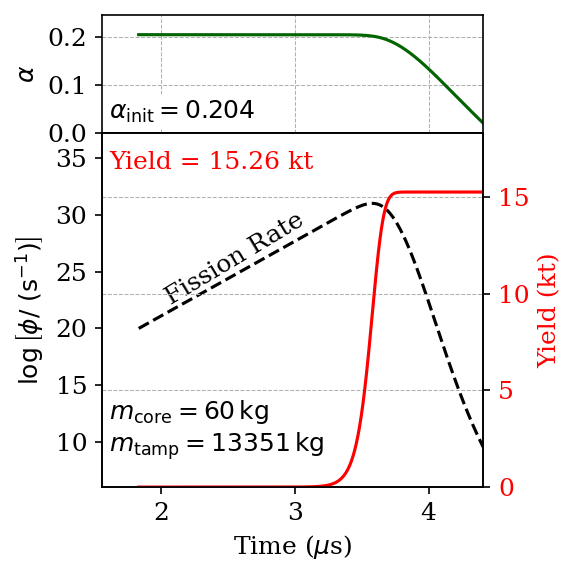

In [20]:
# =====================
# Run Simulation &
#   Generate Output
# =====================

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
import numpy as np

# =====================
# Simulation Parameters
# =====================


CORMASS = 60
MASSTAMP = 13351
concentration = 0.6  #Enrichment



#Cross Sections (in barns)
sigma_f_235 = 1.24
sigma_f_238 = 0.10  #0.302
sigma_el_235 = 3.557
sigma_el_238 = 4.827
sigma_in_235 = 1.926
sigma_in_238 = 2.541
sigma_tr_235 = sigma_el_235 + 0.5 * sigma_in_235
sigma_tr_238 = sigma_el_238 + 0.5 * sigma_in_238
#Neutrons per fission
nu_235 = 2.57
nu_238 = 2.28

A_eff = concentration*235.05 + (1-concentration) *238.05
sigma_f_eff = concentration * sigma_f_235 + (1-concentration) * sigma_f_238
sigma_tr_eff = concentration * sigma_tr_235 + (1-concentration) * sigma_tr_238

eta = 1 ## Effective neutron reduction for absorption
nu_eff = eta*(nu_235 * concentration * (sigma_f_235/sigma_f_eff) + nu_238 * (1-concentration) * (sigma_f_238/sigma_f_eff))
#print(A_eff, sigma_f_eff, sigma_tr_eff, nu_eff)

rho_core = 19.05 #19.05 or 18.71

# Tamper properties
rho_WC = 14.8
A_WC = 195.84
sigma_el_WC = 6.587

# Time Steps
DT=0.15e-9  #Suggestion, vary by a factor of 2 in both directions to confirm convergence of final yield. DT=1e-9 works well and runs quickly, but lowers the yield slightly.
TIME=DT     #Placeholder for first timestep, overwritten later to start at log10[fissrate/s^(-1)]=20


# Function call to run the bomb.
# Input explanation:
# Line 1: Core nuclear physics and properties, calculated above
# Line 2: WC Tamper properties are hardcoded in.
# Line 3: The core and tamper mass.
# Line 4: Equation of state gamma (0.333), the number of initial neutrons (1), first timestep, later timestep. Note that yield varies slightly with initial neutron number.
time_vals, alpha_vals, core_radius_vals, rho_core_vals, tamper_radius_vals, rho_tamp_vals, log_fissrate_vals, log_press_vals, yield_vals = run_simulation(
    rho_core, A_eff, sigma_f_eff, sigma_tr_eff, nu_eff,
    14.8, 195.84, 6.587,
    CORMASS, MASSTAMP,
    0.333333333, 1, TIME, DT
)


# =====================
# Burn Characterization
# =====================

# 1. Max of log_fissrate_vals
max_log_fissrate = np.max(log_fissrate_vals)

# 2. time_vals corresponding to that max
idx_max_fissrate = np.argmax(log_fissrate_vals)
time_at_max_fissrate = time_vals[idx_max_fissrate]

# 3. yield_vals at max log_fissrate divided by final yield_vals
final_yield = yield_vals[-1]
yield_at_max_fissrate = yield_vals[idx_max_fissrate]
yield_ratio = yield_at_max_fissrate / final_yield

# 4. time_vals where yield_vals is closest to 99% of final yield
target_yield = 0.99 * final_yield
idx_closest_99 = np.argmin(np.abs(yield_vals - target_yield))
time_at_99_yield = time_vals[idx_closest_99]

# 5. Initial core density (at t=0)
initial_rho_core = rho_core_vals[0]

# 6. Core density at time closest to 99% yield
rho_core_at_99 = rho_core_vals[idx_closest_99]

# 7. log_fissrate at time closest to 99% yield
log_fissrate_at_99 = log_fissrate_vals[idx_closest_99]

# 8. Efficiency
efficiency = (final_yield * 0.05122) / CORMASS


# Print results
print(f"{'Parameter':<35} {'Value'}")
print("="*50)  # separator for clarity

print(f"{'Final yield:':<35} {final_yield:.3f}")
print(f"{'Initial alpha:':<35} {alpha_vals[0]:.3f}")
print(f"{'Efficiency:':<35} {efficiency * 100:.3f}%")
print()  # Blank line for separation
print(f"{'Max log_fissrate:':<35} {max_log_fissrate:.3f}")
print(f"{'Fraction of full yield at maxfiss:':<35} {yield_ratio * 100:.3f}%")
print(f"{'Time at max log_fissrate:':<35} {time_at_max_fissrate:.3f}")
print(f"{'Time at 99% of final yield:':<35} {time_at_99_yield:.3f}")
print()  # Blank line for separation
print(f"{'Initial rho_core:':<35} {initial_rho_core:.3f}")
print(f"{'rho_core at 99% yield:':<35} {rho_core_at_99:.3f}")
print(f"{'log_fissrate at 99% yield:':<35} {log_fissrate_at_99:.3f}")


# =====================
# Plot Styling
# =====================
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

# =====================
# Extract Data Arrays
# =====================
time_ms       = time_vals
alpha         = alpha_vals
core_radius   = core_radius_vals
tamper_radius = tamper_radius_vals
rho_core      = rho_core_vals
rho_tamp      = rho_tamp_vals
pressure      = log_press_vals
fission_rate  = log_fissrate_vals
yield_kt      = yield_vals

# =====================
# Set Up Plot
# =====================
fig = plt.figure(figsize=(4, 4), dpi=150)
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3], hspace=0)

# --- Top Panel: Alpha ---
ax_alpha = fig.add_subplot(gs[0])
ax_alpha.plot(time_ms, alpha, color='darkgreen', linewidth=1.5)
ax_alpha.set_ylabel(r'$\alpha$', fontsize=12)
ax_alpha.grid(True, linestyle='--', linewidth=0.5)
ax_alpha.tick_params(labelbottom=False)

# Set dynamic y-limits and ticks
ylim_max = 1.2 * alpha_vals[1]
def round_to_nice(x):
    nice_steps = [0.05, 0.10, 0.15, 0.20, 0.25, 0.5, 1.0]
    return min(nice_steps, key=lambda ns: abs(ns - x))
nice_step = round_to_nice(ylim_max / 2)
ax_alpha.set_ylim(0, ylim_max)
ax_alpha.yaxis.set_major_locator(mticker.MultipleLocator(nice_step))

# --- Bottom Panel: Fission Rate & Yield ---
ax_fission = fig.add_subplot(gs[1], sharex=ax_alpha)
ax_yield = ax_fission.twinx()

# Plot fission rate (right y-axis)
ax_fission.plot(time_ms, fission_rate, color='black', linestyle='--', linewidth=1.5)
ax_fission.set_ylabel(r'$\log\left[\phi/\ (\mathrm{s}^{-1})\right]$', fontsize=12, color='black')
ax_fission.tick_params(axis='y', labelcolor='black')
ax_fission.set_ylim(6, 1.2*max_log_fissrate)
ax_yield.set_xlim(0.85*time_vals[1], time_vals[-1])


# Plot yield (left y-axis)
ax_yield.plot(time_ms, yield_kt, color='red', linewidth=1.5)
ax_yield.set_ylabel('Yield (kt)', fontsize=12, color='red')
ax_yield.tick_params(axis='y', labelcolor='red')
ax_yield.set_ylim(0, 1.2*yield_vals[-1])
ax_yield.grid(True, linestyle='--', linewidth=0.5)

# X-axis label
ax_fission.set_xlabel(r'Time ($\mu$s)', fontsize=12)



# ===========================
# Label: Rotated Fission Text
# ===========================

# Note that this label can be buggy and miss the angle by a few degrees
# Generally it does a good job matching the slope of the line, but
# it is very sensitive to exact plot dimensions. For example, if the yield
# tic labels become too large (for example, rather than [0, 5, 10] they look like
# [0, 4.25, 8.5, 12.75, 17], then the added decimals compress the plot area and seem
# to skew the label.
# This can usually be fixed by hand by changing this line which sets the rotation angle:
#    angle = np.degrees(np.arctan2(dy_scaled, dx_scaled))
# And subtracting a few degrees, usually 2, e.g.:
#    angle = np.degrees(np.arctan2(dy_scaled, dx_scaled)) - 2
#
# Also note that the label in the bottom right with masses can be wide for large
# tamper masses, and the white background in that label can clip the red line.

def place_label_along_curve(ax, x_data, y_data, x_target, text, color='black', fontsize=12, y_offset=0.5):
    """
    Places a label along a curve at x_target, rotated to match the curve slope (visually).
    Assumes axes are roughly square.
    """
    import numpy as np

    x_data = np.array(x_data)
    y_data = np.array(y_data)

    # Find the index closest to x_target
    idx = np.argmin(np.abs(x_data - x_target))

    # Use finite difference to estimate slope
    if idx <= 0:
        idx0, idx1 = 0, 1
    elif idx >= len(x_data) - 1:
        idx0, idx1 = -2, -1
    else:
        idx0, idx1 = idx - 1, idx + 1

    dx = x_data[idx1] - x_data[idx0]
    dy = y_data[idx1] - y_data[idx0]

    # Scale slope by axis ranges to match plot aspect ratio
    x_range = ax.get_xlim()
    y_range = ax.get_ylim()
    dx_scaled = dx / (x_range[1] - x_range[0])
    dy_scaled = dy / (y_range[1] - y_range[0])

    angle = np.degrees(np.arctan2(dy_scaled, dx_scaled))

    # Place label just above the curve at x_target
    x = x_data[idx]
    y = y_data[idx] + y_offset  # Adjust offset as needed

    ax.text(
        x, y, text,
        fontsize=fontsize,
        color=color,
        rotation=angle,
        rotation_mode='anchor',
        verticalalignment='bottom',
        horizontalalignment='left',
        clip_on=True
    )


idx_10pct = int(0.1 * len(time_ms))
idx_10pct = max(0, min(idx_10pct, len(time_ms) - 1))
x_target_10pct = time_ms[idx_10pct]

place_label_along_curve(
    ax=ax_fission,
    x_data=time_ms,
    y_data=fission_rate,
    x_target=x_target_10pct,
    text='Fission Rate',
    color='black',
    fontsize=12,
    y_offset=0.0
)




# =====================
# Annotations
# =====================
ax_yield.text(
    0.02, 0.07,
    rf'$m_{{\rm core}} = {CORMASS:.0f} \, \rm{{kg}}$' + '\n' + rf'$m_{{\rm tamp}} = {MASSTAMP:.0f} \, \rm{{kg}}$',
    transform=ax_yield.transAxes,
    fontsize='medium',
    verticalalignment='bottom',
    horizontalalignment='left',
    bbox=dict(facecolor='white', edgecolor='none', pad=2.0)
)

ax_yield.text(
    0.02, 0.95,
    f'Yield = {yield_kt[-1]:.2f} kt',
    transform=ax_yield.transAxes,
    fontsize='medium',
    color='red',
    verticalalignment='top',
    horizontalalignment='left',
    bbox=dict(facecolor='white', edgecolor='none', pad=2.0)
)

ax_alpha.text(
    0.02, 0.07,
    rf'$\alpha_{{\rm init}} = {alpha[0]:.3f}$',
    transform=ax_alpha.transAxes,
    fontsize='medium',
    verticalalignment='bottom',
    horizontalalignment='left',
    bbox=dict(facecolor='white', edgecolor='none', pad=2.0)
)

# X-axis limits

# =====================
# Save and Show
# =====================
plt.tight_layout()
#plt.savefig("alpha_yield_fissionrate", bbox_inches='tight')
plt.show()


In [38]:

# =====================
# Example: Little Boy
# =====================

# 64 kg 0.8 enrichment with 300 kg WC surrounded by 2000 kg steel approximated as 1300 kg WC.
# Values hard coded, assumes sigma_f^{238U} = 0.10 barns.

time_vals, alpha_vals, core_radius_vals, rho_core_vals, tamper_radius_vals, rho_tamp_vals, log_fissrate_vals, log_press_vals, yield_vals = run_simulation(
    19.05, 235.65, 1.012, 4.8355, 2.5643,
    14.8, 195.84, 6.587,
    64.0, 1300.0,
    0.333333333, 1, 0.01e-6, 0.1e-9
)

print(f"Little boy using sigma_f^238U = 0.10 barns.")
print(f"{'Final yield:':<35} {yield_vals[-1]:.3f}")
print(f"{'Initial alpha:':<35} {alpha_vals[0]:.3f}")
print(f"") #lineskip

# Values hard coded, assumes sigma_f^{238U} = 0.15 barns.

time_vals, alpha_vals, core_radius_vals, rho_core_vals, tamper_radius_vals, rho_tamp_vals, log_fissrate_vals, log_press_vals, yield_vals = run_simulation(
    19.05, 235.65, 1.022, 4.8355, 2.56148,
    14.8, 195.84, 6.587,
    64.0, 1300.0,
    0.333333333, 1, 0.01e-6, 0.1e-9
)
print(f"Little boy using sigma_f^238U = 0.15 barns.")
print(f"{'Final yield:':<35} {yield_vals[-1]:.3f}")
print(f"{'Initial alpha:':<35} {alpha_vals[0]:.3f}")

Little boy using sigma_f^238U = 0.10 barns.
Final yield:                        12.120
Initial alpha:                      0.389

Little boy using sigma_f^238U = 0.15 barns.
Final yield:                        12.767
Initial alpha:                      0.394


# Run a grid and generate tables

In [21]:
import numpy as np

masscore_values = np.array([80, 70, 60, 50, 40, 35])  # Keep descending order for running, at the lowest failing mass it will skip the error and jump to the next mass.
masstamp_values = np.array([1634.289524, 3928.07104, 7709.710837, 13351.17348, 21224.42355])

# Physics constants (unchanged)
concentration = 0.6
A_eff = concentration*235.05 + (1-concentration)*238.05
sigma_f_235 = 1.24
sigma_f_238 = 0.10
sigma_el_235 = 3.557
sigma_el_238 = 4.827
sigma_in_235 = 1.926
sigma_in_238 = 2.541
sigma_tr_235 = sigma_el_235 + 0.5 * sigma_in_235
sigma_tr_238 = sigma_el_238 + 0.5 * sigma_in_238
nu_235 = 2.57
nu_238 = 2.28
eta = 1
sigma_f_eff = concentration * sigma_f_235 + (1-concentration) * sigma_f_238
sigma_tr_eff = concentration * sigma_tr_235 + (1-concentration) * sigma_tr_238
nu_eff = eta*(nu_235 * concentration * (sigma_f_235 / sigma_f_eff) + nu_238 * (1-concentration) * (sigma_f_238 / sigma_f_eff))

rho_core = 19.05
rho_WC = 14.8
A_WC = 195.84
sigma_el_WC = 6.587

print("Constants:")
print(f"A_eff={A_eff:.3f}, sigma_f_eff={sigma_f_eff:.3f}, sigma_tr_eff={sigma_tr_eff:.3f}, nu_eff={nu_eff:.3f}\n")

n_masstamp = len(masstamp_values)
n_masscore = len(masscore_values)

# Initialize arrays to hold results for each run (rows=masstamp, cols=masscore)
initial_alpha = np.full((n_masstamp, n_masscore), np.nan)
max_log_fissrate = np.full((n_masstamp, n_masscore), np.nan)
time_at_max_fissrate = np.full((n_masstamp, n_masscore), np.nan)
yield_ratio_at_max_fissrate = np.full((n_masstamp, n_masscore), np.nan)
rho_core_at_99yield = np.full((n_masstamp, n_masscore), np.nan)
log_fissrate_at_99yield = np.full((n_masstamp, n_masscore), np.nan)
time_at_99yield = np.full((n_masstamp, n_masscore), np.nan)
final_yield_vals = np.full((n_masstamp, n_masscore), np.nan)

print("Starting simulations...\n")

for i_masstamp, masstamp in enumerate(masstamp_values):
    print(f"=== MASSTAMP = {masstamp:.2f} kg ===")

    for i_masscore, masscore in enumerate(masscore_values):  # run in original descending order

        try:
            (
                time_vals, alpha_vals, core_radius_vals, rho_core_vals,
                tamper_radius_vals, rho_tamp_vals, log_fissrate_vals,
                log_press_vals, yield_vals
            ) = run_simulation(
                rho_core, A_eff, sigma_f_eff, sigma_tr_eff, nu_eff,
                rho_WC, A_WC, sigma_el_WC,
                masscore, masstamp,
                0.333333333, 1, 1.0e-6, 0.1e-9
            )
        except Exception as e:
            print(f"Simulation failed for MASSCORE={masscore}, MASSTAMP={masstamp}: {e}")
            break

        final_yield = yield_vals[-1]
        final_yield_vals[i_masstamp, i_masscore] = final_yield

        if final_yield < 3e-2:
            print(f"Yield too low ({final_yield:.4f}) — skipping remaining MASSCORE for MASSTAMP={masstamp}\n")
            break

        initial_alpha[i_masstamp, i_masscore] = alpha_vals[0]

        idx_max_fissrate = np.nanargmax(log_fissrate_vals)
        max_log_fissrate[i_masstamp, i_masscore] = log_fissrate_vals[idx_max_fissrate]
        time_at_max_fissrate[i_masstamp, i_masscore] = time_vals[idx_max_fissrate]

        yield_ratio_at_max_fissrate[i_masstamp, i_masscore] = yield_vals[idx_max_fissrate] / final_yield

        target_yield = 0.99 * final_yield
        idx_99 = np.nanargmin(np.abs(yield_vals - target_yield))

        rho_core_at_99yield[i_masstamp, i_masscore] = rho_core_vals[idx_99]
        log_fissrate_at_99yield[i_masstamp, i_masscore] = log_fissrate_vals[idx_99]
        time_at_99yield[i_masstamp, i_masscore] = time_vals[idx_99]

print("\nAll simulations complete!\n")

# Prepare indices to reorder columns for display by ascending masscore
col_order = np.argsort(masscore_values)
masscore_values_sorted = masscore_values[col_order]

def print_table(data, row_labels, col_labels, title, fmt=".4f"):
    print(f"--- {title} ---")
    header = "MASSTAMP \\ MASSCORE | " + " | ".join([f"{v:.1f}" for v in col_labels])
    print(header)
    print("-" * len(header))
    for i, row_val in enumerate(row_labels):
        # Reorder columns for display
        row_data = data[i, col_order]
        row_str = f"{row_val:14.2f} | " + " | ".join([f"{x:{fmt}}" if not np.isnan(x) else "  nan" for x in row_data])
        print(row_str)
    print()

# Print tables with masstamp rows and masscore columns sorted ascending
#print_table(final_yield_vals, masstamp_values, masscore_values_sorted, "Final yield_vals")
#print_table(initial_alpha, masstamp_values, masscore_values_sorted, "Initial alpha_vals")
#print_table(max_log_fissrate, masstamp_values, masscore_values_sorted, "Max log_fissrate_vals")
#print_table(time_at_max_fissrate, masstamp_values, masscore_values_sorted, "Time at max log_fissrate")
#print_table(yield_ratio_at_max_fissrate, masstamp_values, masscore_values_sorted, "Yield at max log_fissrate / Final yield")
#print_table(rho_core_at_99yield, masstamp_values, masscore_values_sorted, "rho_core_vals at 99% final yield")
#print_table(log_fissrate_at_99yield, masstamp_values, masscore_values_sorted, "log_fissrate_vals at 99% final yield")
#print_table(time_at_99yield, masstamp_values, masscore_values_sorted, "Time at 99% final yield")


Constants:
A_eff=236.250, sigma_f_eff=0.784, sigma_tr_eff=5.151, nu_eff=2.555

Starting simulations...

=== MASSTAMP = 1634.29 kg ===
Yield too low (0.0210) — skipping remaining MASSCORE for MASSTAMP=1634.289524

=== MASSTAMP = 3928.07 kg ===
Yield too low (0.0095) — skipping remaining MASSCORE for MASSTAMP=3928.07104

=== MASSTAMP = 7709.71 kg ===
=== MASSTAMP = 13351.17 kg ===
=== MASSTAMP = 21224.42 kg ===

All simulations complete!



In [24]:

# Print tables with masstamp rows and masscore columns sorted ascending
print_table(final_yield_vals, masstamp_values, masscore_values_sorted, "Final yield_vals")
print_table(initial_alpha, masstamp_values, masscore_values_sorted, "Initial alpha_vals")
print_table(max_log_fissrate, masstamp_values, masscore_values_sorted, "Max log_fissrate_vals")
print_table(time_at_max_fissrate, masstamp_values, masscore_values_sorted, "Time at max log_fissrate")
print_table(yield_ratio_at_max_fissrate, masstamp_values, masscore_values_sorted, "Yield at max log_fissrate / Final yield")
print_table(rho_core_at_99yield, masstamp_values, masscore_values_sorted, "rho_core_vals at 99% final yield")
print_table(log_fissrate_at_99yield, masstamp_values, masscore_values_sorted, "log_fissrate_vals at 99% final yield")
print_table(time_at_99yield, masstamp_values, masscore_values_sorted, "Time at 99% final yield")


#NOTE, EFFICIENCY TABLE CAN BE BUGGY, MAKE CHANGES AT YOUR OWN RISK.
# Compute the efficiency using the original `masscore_values`
efficiency_vals = (final_yield_vals * 0.05122) / masscore_values * 100  # Efficiency as percentage

# Print the efficiency table directly
print("--- Efficiency (%) ---")
header = "MASSTAMP \\ MASSCORE | " + " | ".join([f"{v:.1f}" for v in masscore_values_sorted])
print(header)
print("-" * len(header))
for i, row_val in enumerate(masstamp_values):
    # Reorder columns for display (sorted columns)
    row_data = efficiency_vals[i, col_order]
    row_str = f"{row_val:14.2f} | " + " | ".join([f"{x:.3f}" if not np.isnan(x) else "  nan" for x in row_data])
    print(row_str)
print()


--- Final yield_vals ---
MASSTAMP \ MASSCORE | 35.0 | 40.0 | 50.0 | 60.0 | 70.0 | 80.0
-------------------------------------------------------------
       1634.29 |   nan | 0.0210 | 0.4147 | 1.5268 | 3.4550 | 6.2004
       3928.07 | 0.0095 | 0.1544 | 1.3820 | 4.2883 | 9.0548 | 15.6691
       7709.71 | 0.0513 | 0.4169 | 2.9633 | 8.7286 | 18.0745 | 30.9763
      13351.17 | 0.1280 | 0.8131 | 5.2773 | 15.2693 | 31.4270 | 53.6958
      21224.42 | 0.2401 | 1.3577 | 8.4728 | 24.3574 | 50.0195 | 85.3521

--- Initial alpha_vals ---
MASSTAMP \ MASSCORE | 35.0 | 40.0 | 50.0 | 60.0 | 70.0 | 80.0
-------------------------------------------------------------
       1634.29 |   nan |   nan | 0.1239 | 0.1956 | 0.2590 | 0.3153
       3928.07 |   nan | 0.0606 | 0.1346 | 0.2028 | 0.2643 | 0.3193
       7709.71 | 0.0304 | 0.0658 | 0.1370 | 0.2041 | 0.2650 | 0.3198
      13351.17 | 0.0336 | 0.0676 | 0.1376 | 0.2043 | 0.2651 | 0.3199
      21224.42 | 0.0350 | 0.0682 | 0.1378 | 0.2044 | 0.2652 | 0.3199

---

# Run a grid and generate yields vs core mass for various tamper masses and plot constraint bands

To get bounds for your color band, you will need to run the first cell twice, changing the last line to store your upperlimit summary_array in summary_array_015 and your lowerlimit summary_array in summary_array_010. The plot expects these two arrays as upper and lower bounds.

Note that we use the larger timestep dt=1e-9 here, otherwise this takes too long. The error this introduces to the yield is only a few percent and that is not noticable when plotting log(yield)

In [27]:
import numpy as np

#masscore_values = np.arange(80, 30, -1)   # Runs slow, very smooth.
masscore_values = np.array([70, 60, 50, 40, 35])  # Runs fast, generates the example output below.

#masstamp_values = np.array([
#    1634.289524, 2618.4, 3928.07104,
#    5609.660867, 7709.710837, 13351.17348, 21224.42355
#])
masstamp_values = np.array([1634.289524 ,		3928.07104,	7709.710837,	13351.17348,	21224.42355]) # List of 30, 40, 50, 60, and 70 cm tampers for a 50 kg core.

#Example call with LittleBoy values

#time_vals, alpha_vals, core_radius_vals, rho_core_vals, tamper_radius_vals, rho_tamp_vals, log_fissrate_vals, log_press_vals, yield_vals = run_simulation(
#    18.71, 235.04, 1.012, 4.8355, 2.5643,
#    14.8, 195.84, 6.587,
#    64.0, 550.0,
#    0.333333333, 1, 0.01e-6, 9.0e-9
#)

concentration = 0.6
A_eff = concentration*235.05 + (1-concentration) *238.05
sigma_f_235 = 1.24
sigma_f_238 = 0.10 #0.15
sigma_el_235 = 3.557
sigma_el_238 = 4.827
sigma_in_235 = 1.926
sigma_in_238 = 2.541
sigma_tr_235 = sigma_el_235 + 0.5 * sigma_in_235
sigma_tr_238 = sigma_el_238 + 0.5 * sigma_in_238
nu_235 = 2.57
nu_238 = 2.28
eta = 1 ## Effective neutron reduction for absorption
sigma_f_eff = concentration * sigma_f_235 + (1-concentration) * sigma_f_238
sigma_tr_eff = concentration * sigma_tr_235 + (1-concentration) * sigma_tr_238
nu_eff = nu_235 * concentration * (sigma_f_235/sigma_f_eff) + nu_238 * (1-concentration) * (sigma_f_238/sigma_f_eff)
print(A_eff, sigma_f_eff, sigma_tr_eff, nu_eff)

rho_core = 19.05 #19.05  or 18.71?
rho_WC = 14.8
A_WC = 195.84
sigma_el_WC = 6.587


summary = []
print(A_eff, sigma_f_eff, sigma_tr_eff, nu_eff)
for masstamp in masstamp_values:
    print(f"\n=== Starting MASSTAMP = {masstamp:.2f} kg ===")

    for masscore in masscore_values:
        #print(f"\nRunning simulation with MASSCORE = {masscore} kg")

        try:
            (
                time_vals, alpha_vals, core_radius_vals, rho_core_vals,
                tamper_radius_vals, rho_tamp_vals, log_fissrate_vals,
                log_press_vals, yield_vals
            ) = run_simulation(
                rho_core, A_eff, sigma_f_eff, sigma_tr_eff, nu_eff,
                14.8, 195.84, 6.587,
                masscore, masstamp,
                0.333333333, 1, 1.0e-6, 1.0e-9
            )
        except Exception as e:
            print(f"Simulation failed for MASSCORE = {masscore}, MASSTAMP = {masstamp}: {e}")
            break  # skip remaining masscore values for this masstamp

        final_yield = yield_vals[-1]
        final_time = time_vals[-1]
        #print(f"Final yield: {final_yield:.4f} kT at {final_time:.3f} μs")

        summary.append([masscore, masstamp, final_yield])

        if final_yield < 3e-2:
            print("Yield too low — skipping remaining MASSCORE values for this MASSTAMP.\n")
            break  # stop scanning masscore, move to next masstamp

summary_array = np.array(summary)

summary_array_010 = np.array(summary)
#summary_array_015 = np.array(summary)



236.25 0.784 5.151 2.5552040816326524
236.25 0.784 5.151 2.5552040816326524

=== Starting MASSTAMP = 1634.29 kg ===
Yield too low — skipping remaining MASSCORE values for this MASSTAMP.


=== Starting MASSTAMP = 3928.07 kg ===
Yield too low — skipping remaining MASSCORE values for this MASSTAMP.


=== Starting MASSTAMP = 7709.71 kg ===

=== Starting MASSTAMP = 13351.17 kg ===

=== Starting MASSTAMP = 21224.42 kg ===


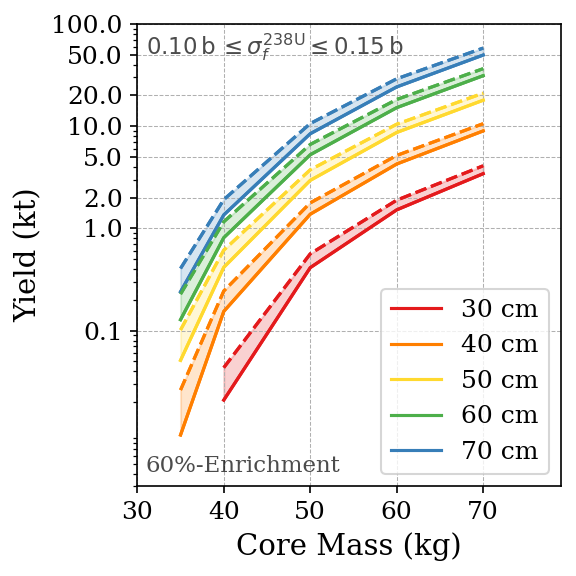

In [28]:
# PLOTTING

# =============================
# STEP 1: Imports and Settings
# =============================
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Plot styling
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

# Full color list (ColorBrewer Set1 + extensions)
colors = ['#E41A1C', '#FF7F00', '#FFD92F', '#4DAF4A', '#377EB8', '#984EA3', '#A65628']
marker_styles = ['^', 'o', 's', 'D', '<', '>', '*']

# =============================
# STEP 2: Data Preparation
# =============================

# summary_array_010 and summary_array_015 must be defined before this
# Each should be shaped (N, 3): [masscore, masstamp, yield]

unique_masstamps = np.unique(summary_array_010[:, 1])

# =============================
# STEP 3: Plotting
# =============================


fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

xlim = (30, 79)
ylim = (0.003, 100)

legend_labels = ['30 cm', '40 cm', '50 cm', '60 cm', '70 cm']

def plot_summary_array(summary_array, linestyle, alpha=1.0):
    unique_masstamps = np.unique(summary_array[:, 1])

    for i, masstamp in enumerate(unique_masstamps):
        mask = summary_array[:, 1] == masstamp
        subset = summary_array[mask]

        # Sort by core mass
        sorted_idx = np.argsort(subset[:, 0])
        masscore = subset[sorted_idx, 0]
        yields = subset[sorted_idx, 2]

        # Filter by xlim and ylim
        valid = (
            (masscore >= xlim[0]) & (masscore <= xlim[1]) &
            (yields >= ylim[0]) & (yields <= ylim[1])
        )
        masscore = masscore[valid]
        yields = yields[valid]

        if len(masscore) == 0:
            continue  # Skip if no valid points

        if linestyle == '-':
            label = legend_labels[i]  # Use predefined label for solid lines
        else:
            label = '_nolegend_'  # Skip legend for dashed lines

        ax.plot(masscore, yields,
                linestyle=linestyle,
                marker='',
                label=label,
                color=colors[i % len(colors)],
                alpha=alpha)


# Plot both datasets
plot_summary_array(summary_array_010, linestyle='-')#, label_suffix=' (0.10 b)')
plot_summary_array(summary_array_015, linestyle='--')#, label_suffix=' (0.15 b)')


# =============================
# STEP 4: Axis & Layout
# =============================

ax.set_xlim(30, 79)
ax.set_ylim(0.003, 100)

ax.set_xlabel('Core Mass (kg)')
ax.set_ylabel('Yield (kt)')

ax.grid(True, linestyle='--', linewidth=0.5)
ax.legend(loc='lower right', frameon=True)

# =============================
# STEP 5: Annotations
# =============================

ax.text(0.02, 0.984, r"$0.10 \, \mathrm{b} \, \leq \sigma_f^{\mathrm{238U}} \leq 0.15 \, \mathrm{b} $",
        transform=ax.transAxes,
        fontsize=11,
        verticalalignment='top',
        horizontalalignment='left',
        alpha=0.7)

ax.text(0.02, 0.02, r"60%-Enrichment",
        transform=ax.transAxes,
        fontsize=11,
        verticalalignment='bottom',
        horizontalalignment='left',
        alpha=0.7)


# =============================
# STEP 6: Finalize
# =============================


def plot_with_shading(summary_010, summary_015):
    unique_masstamps = np.unique(summary_010[:, 1])

    for i, masstamp in enumerate(unique_masstamps):
        mask_010 = summary_010[:, 1] == masstamp
        mask_015 = summary_015[:, 1] == masstamp

        subset_010 = summary_010[mask_010]
        subset_015 = summary_015[mask_015]

        # Sort by masscore
        subset_010 = subset_010[np.argsort(subset_010[:, 0])]
        subset_015 = subset_015[np.argsort(subset_015[:, 0])]

        # Extract aligned values
        masscore_010, yield_010 = subset_010[:, 0], subset_010[:, 2]
        masscore_015, yield_015 = subset_015[:, 0], subset_015[:, 2]

        # Ensure x-values align before shading
        common_mask = np.isin(masscore_010, masscore_015)
        x_vals = masscore_010[common_mask]

        # Interpolate yields to same x-axis
        y1 = np.interp(x_vals, masscore_010, yield_010)
        y2 = np.interp(x_vals, masscore_015, yield_015)

        # Filter x_vals/y1/y2 by axis limits
        valid = (
            (x_vals >= xlim[0]) & (x_vals <= xlim[1]) &
            (y1 >= ylim[0]) & (y1 <= ylim[1]) &
            (y2 >= ylim[0]) & (y2 <= ylim[1])
        )
        x_vals, y1, y2 = x_vals[valid], y1[valid], y2[valid]

        if len(x_vals) == 0:
            continue

        ax.fill_between(x_vals, y1, y2,
                        color=colors[i % len(colors)],
                        alpha=0.2, label='_nolegend_')


plot_summary_array(summary_array_010, linestyle='-')
plot_summary_array(summary_array_015, linestyle='--')
plot_with_shading(summary_array_010, summary_array_015)


ax.set_yscale('log')
ax.set_yticks([0.1, 1, 2, 5, 10, 20, 50, 100])
ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(ticker.NullFormatter())

plt.tight_layout()
plt.savefig("yield_vs_coremass_both_sigmas_rhoc1905.pdf", bbox_inches='tight')
plt.show()
